In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

import tree_structure
import fitting_tools
import objective_builders

# Examining Single-Feature Splitting

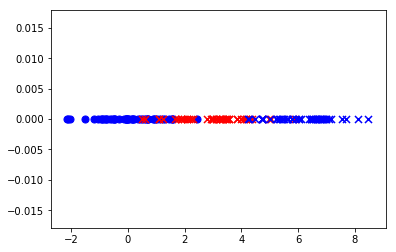

In [778]:
# generate two-gaussian data samples
# class one
n1 = 50
n2 = 50
n3 = 50
X1 = 1.1*np.random.randn(n1)
X2 = np.random.randn(n2) + 3
X3 = np.random.randn(n2) + 6

plt.scatter(X1, np.zeros(n1), marker='o', color='b', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.scatter(X3, np.zeros(n3), marker='x', color='b', s=50)

X = np.concatenate((X1,X3,X2))
labels = np.ones(len(X))
labels[len(X1)+len(X3):] = 2

## Splitting with C4.5

In [260]:
# going through the mid-points one-by-one

# number of classes
c = len(np.unique(labels))

# sorting the data
inds = np.argsort(X)
scores = np.zeros(n1+n2-1)
thetas = np.zeros(n1+n2-1)
eps = 1e-6
for i in range(n1+n2-1):
    thetas[i] = (X[inds[i]] + X[inds[i+1]]) / 2.
    prop = np.zeros((2,c))
    
    # proportions of the classes
    for j in range(c):
        # left side
        prop[0,j] = np.sum(labels[X <= thetas[i]]==j+1) / float(i+1)
        # right side
        prop[1,j] = np.sum(labels[X > thetas[i]]==j+1) / float(n1+n2-(i+1))
        
    # entropy
    entropies = -np.sum((prop+eps) * np.log(prop+eps), axis=1)
    scores[i] = ((i+1)*entropies[0] + (n1+n2-i-1)*entropies[1]) / (n1+n2)

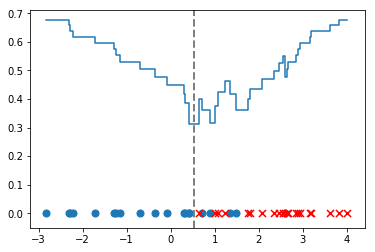

In [292]:
# the result:
best_theta = thetas[np.argmin(scores)]

plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

plt.step(X[inds], np.append(scores[0],scores))
plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')

## Splitting with Densities

First, let's do a density estimation for each class. Here, we do kernel density estimation (KDE):
$$p(x|y=j) = \frac{1}{n_j}\sum_{y_i=j} k_G(x,x_i)=\frac{1}{n_j\sqrt{2\pi}\sigma}\sum_{y_i=j}e^{-(x-x_i)^2/2\sigma} $$

In [167]:
sigma = .5

# defining KDE function with Gaussian kernel
def class_kernel_1D(dat, x, sigma):
    density_val = 0
    n = dat.shape
    for i in range(len(dat)):
        density_val += np.exp(-(dat[i]-x)**2/(2*sigma)) / (sigma*np.sqrt(2*np.pi))
    return density_val

kernel_c1 = lambda x: class_kernel_1D(X[labels==1], x, sigma)
kernel_c2 = lambda x: class_kernel_1D(X[labels==2], x, sigma)


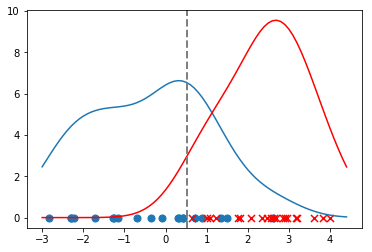

In [171]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
plt.plot(eval_points, kernel_c1(eval_points))
plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')

Now, let's form the density-based objective:
$$ -\sum_{j=1}^2 \mathbb{P}(y=j|x\leq \theta) \log\mathbb{P}(y=j|x\leq \theta)$$

where from Bayes rule
$$ \mathbb{P}(y=j|x\leq \theta) = \frac{\mathbb{P}(x\leq\theta|y=j)\cdot\mathbb{P}(y=j)}{\mathbb{P}(x\leq\theta)}.$$

After some simplifications, we get the following objective:
$$ J(\theta) = -\mathbb{E}_y[KL(q(\theta, y), q'(\theta)],$$
where "KL" is the KL-divergence measure, $q_1$ and $q_2$ are two two-element PMFs whose mass probabilities depend on $\theta$:
$$q(\theta,y) = [\mathbb{P}(x\leq\theta|y), \mathbb{P}(x>\theta|y)]$$
$$q'(\theta) = [\mathbb{P}(x\leq\theta), \mathbb{P}(x>\theta)]$$

The objective $J(\theta)$ can also be written as
$$ J(\theta) = \sum_{y=1}^c\pi_j\left[q_1(\theta,j)\log\frac{q'_1(\theta)}{q_1(\theta,j)} + q_2(\theta,j)\log\frac{q'_2(\theta)}{q_2(\theta,j)} \right]$$
where, assuming that we are using Gaussian kernels, we get the following for the CDFs:
$$\pi_j = \frac{n_j}{n},$$
$$ q_1(\theta,y=j) = \mathbb{P}(x\leq\theta|y=j)=\int_{-\infty}^\theta p(x|y=j)dx = \frac{1}{n_j}\sum_{y_i=j}\Phi\left(\frac{\theta-x_i}{\sigma}\right).$$
and
$$ q'_1(\theta) = \mathbb{P}(x\leq\theta)=\int_{-\infty}^\theta p(x)dx = \frac{1}{n}\sum_{i=1}^n\Phi\left(\frac{\theta-x_i}{\sigma}\right).$$

In [247]:
# first computing all the variables present in the equations above

# we can generate q_1 and q'_1 values using the following function
q = lambda theta,dat,sigma: np.sum(norm.cdf((theta - dat)/sigma)) / len(dat)

# the objective function J:
def objective_func(X, labels, sigma, q, theta):
    J = 0
    for j in range(c):
        pi = np.sum(labels==j+1) / float(len(X))
        # different terms
        q_1 = q(theta, X[labels==j+1], sigma)
        qpr_1 = q(theta, X, sigma)
        # adding the corresponding term
        J += pi*(q_1*np.log(qpr_1/q_1) + (1-q_1)*np.log((1-qpr_1) / (1-q_1)))
    
    return J

eval_points = np.arange(-3,4.5,.1)
Js = np.zeros(len(eval_points))
for i in range(len(eval_points)):
    theta = eval_points[i]
    Js[i] = objective_func(X, labels, sigma, q, theta)

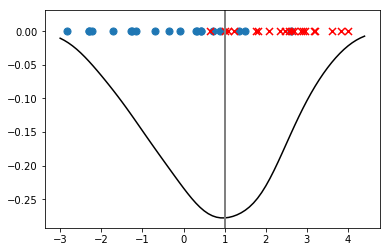

In [251]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.plot(eval_points, Js, color='k')

plt.axvline(eval_points[np.argmin(Js)], linewidth=2, color='gray', linestyle = '-')

Comparing the specified threshold with the empirical one:

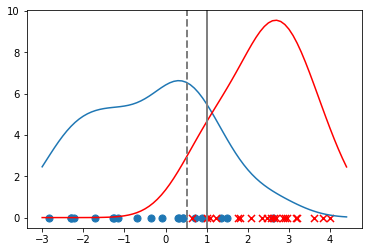

In [250]:
plt.scatter(X1, np.zeros(n1), marker='o', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)

eval_points = np.arange(-3,4.5,.1)
plt.plot(eval_points, kernel_c1(eval_points))
plt.plot(eval_points, kernel_c2(eval_points), color='r')

plt.axvline(best_theta, linewidth=2, color='gray', linestyle = '--')
plt.axvline(eval_points[np.argmin(Js)], linewidth=2, color='gray', linestyle = '-')

# Bisection Method for Finding the Minimizer

Above, we exhaustively searched for the minimizer of the impurity measure. Below we try to design a more principled way of locating the minimum of impurity measure using a bisectioning method. For such method, we need to start from an inerval $[a,b]$ which we assume contains a local minimum $\hat{\theta}$. In our application, we can set this interval to be the range that the variable on focus (the feature we are trying to threshold) changes. This is because, we always need to make sure that each of the child nodes get at least one sample. If we set $\theta$ to be too large or too small, then one of the nodes will lose all the samples and that is not desirable.

In [655]:
# define the objective as a stand-alone function which can be evaluated at any given theta
J_theta = lambda theta: objective_func(X, labels, sigma, q, theta)

# the initial bracket
a = X.min()
b = X.max()

def bisection_min(J_theta, bracket):
    
    # end-points
    a,b = bracket
    J_a, J_b = (J_theta(a), J_theta(b))
    
    # central mid-points
    x_m = (a+b) / 2.
    J_m = J_theta(x_m)    
    
    tol = 1e-6
    
    # repeat bisectioning until the length of the bracket is small enough
    while(np.abs(a-b) > tol):

        # left and right mid-points
        x_l = (a + x_m) / 2.
        x_r = (b + x_m) / 2.
        J_r, J_l = (J_theta(x_r), J_theta(x_l))
        
        J_min = np.min([J_a, J_b, J_m, J_r, J_l])
        
        # updating
        if (J_min == J_a) | (J_min == J_l):
            b, J_b = (x_m, J_m)            
            x_m, J_m = (x_l, J_l)
        elif J_min == J_m:
            a,b = (x_l, x_r)
            J_a, J_b = (J_l, J_r)
        elif (J_min == J_b) | (J_min == J_r):
            a, J_a = (x_m, J_m)            
            x_m, J_m = (x_r, J_r)
        
    return x_m, J_m

In [373]:
bisection_min(J_theta, (a,b)), Js.min()

((0.95758309256991891, -0.27791269658769147), -0.27783387789726777)

# Constructing a General Tree

So far we have the necessary tools for selecting the splitting threshold for any given variable. In this section, we try to get a set of multivariate data samples, and starting from the root, at each node of the tree, we go through all the variables and compute the best threshold. After going through all the variables, we select the one with the smallest minimized objective and its correspondin threshold.

Before that, we write a general functions for computing the class-conditional and marginal CDFs:

In [345]:
sigma = .5

# assuming that dat is 1-dimensional
marginal_CDF = lambda theta,dat,sigma: np.sum(norm.cdf((theta - dat)/sigma)) / len(dat)
class_CDF = lambda theta,dat,labels,y,sigma: marginal_CDF(theta, dat[labels==y], sigma)

In [781]:
reload(fitting_tools)
reload(tree_structure)
reload(objective_builders)
T = tree_structure.Tree(X, labels, objective_builders.normal_CDF)
T.fit_full_tree()
#T.leaves

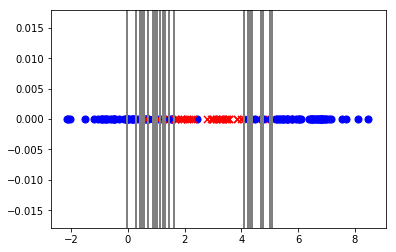

In [786]:
plt.scatter(X1, np.zeros(n1), marker='o', color='b', s=50)
plt.scatter(X2, np.zeros(n2), marker='x', color='r', s=50)
plt.scatter(X3, np.zeros(n2), marker='o', color='b', s=50)
TREE = best_T

for i in TREE.leaf_inds:
    parent = TREE.node_dict[str(i)].parent
    plt.axvline(TREE.node_dict[str(parent)].rule['0'], linewidth=2, color='gray', linestyle = '-')

In [787]:
seq, alphas = T.cost_complexity_seq()

0 siblings have been removed from the tree.


In [782]:
reload(fitting_tools)

scores, best_T = fitting_tools.CV_prune(T, 5)
print scores

0 siblings have been removed from the tree.
Fitting the full tree for CV 0
0 siblings have been removed from the tree.
Fitting the full tree for CV 1
0 siblings have been removed from the tree.
Fitting the full tree for CV 2
0 siblings have been removed from the tree.
Fitting the full tree for CV 3
0 siblings have been removed from the tree.
Fitting the full tree for CV 4
0 siblings have been removed from the tree.
[ 0.22        0.23333333  0.21333333  0.33333333]


## Building the objectives:

The ultimate objective $J(\theta)$ depends only on the marginal and class-conditional CDFs, that is $\mathbb{P}(x\leq\theta)$ and $\mathbb{P}(x\leq\theta|y=j)$ (assuming that $x$ is the particular feature component on focus). When using KDE, these CDFs, in turn, depend on the kernel CDF, defined by
$$F_\Lambda(\theta;x_i) = \int_{\infty}^\theta k(x,x_i),$$

where $x_i$ is a fixed point where the kernel is centered on, and $\Lambda$ are the kernel's parameters (e.g., the bandwidth). Recall, $p(x)=\frac{1}{n}\sum_{i=1}^nk(x,x_i)$ and $p(x|y=j)=\frac{1}{n_j}\sum_{y_i=j}k(x,x_i)$. Then,

$$p(x\leq\theta) = \int_{-\infty}^\theta p(x)dx = \frac{1}{n}\sum_{i=1}^n\int_{-\infty}^\theta k(x,x_i)dx = \frac{1}{n}\sum_{i=1}^n F_{\Lambda}(\theta;x_i).$$

Similar equation can be written for the class-conditional case.

# Testing the Functions

In [606]:
sigmas = [.5]
Js = KDE_1D_obj_builder(X, labels, sigmas, normal_CDF)

T = Tree(X, labels, Js)

#T.fit_full_tree()
T.check_full_stopped()

False

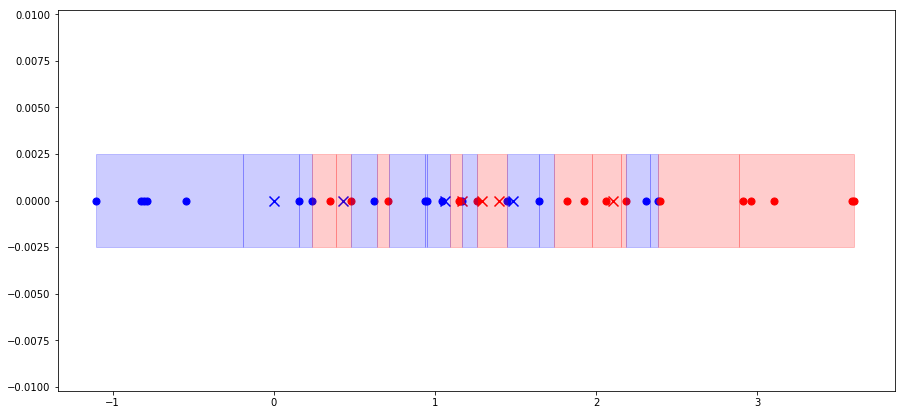

In [707]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

#dat = total_dat[train_inds[cv_ind]]
#tlabels = total_labels[train_inds[cv_ind]]
cv_ind = 0
train_dat = total_dat[train_inds[cv_ind]]
train_labels = total_labels[train_inds[cv_ind]]
#cv_T = tree_structure.Tree(train_dat, train_labels, 
#                              T.kernel_CDF)
#cv_T.fit_full_tree()
TREE = all_seqs[1+cv_ind][0]


# list the thresholds
thetas = []
for i in TREE.node_dict.keys():
    node_obj = TREE.node_dict[i]
    if node_obj.rule:
        thetas += [node_obj.rule['0']]
borders = np.sort(np.concatenate((thetas, np.array([X.min(), X.max()]))))

# list the decisions
decisions = np.zeros(len(borders)-1)
for i in range(len(decisions)):
    test_pnt = np.array([(borders[i] + borders[i+1]) / 2.])
    _, pred = TREE.posteriors_predict(test_pnt)
    decisions[i] = pred[0]
    
# plot the training data
ax.scatter(train_dat[train_labels==1.], np.zeros(np.sum(train_labels==1.)), marker='o', s=50, color='b')
ax.scatter(train_dat[train_labels==2.], np.zeros(np.sum(train_labels==2.)), marker='o', s=50, color='r')

h = 0.0025
for i in range(len(decisions)):
    clr = 'b' if decisions[i]==0. else 'r'
    ax.add_patch(patches.Rectangle((borders[i], h), borders[i+1] - borders[i], -2*h, 
                                    alpha=.2, color=clr))

# now the test sampels
#tedat = total_dat[test_inds[cv_ind]]
#telabels = total_labels[test_inds[cv_ind]]
test_dat = total_dat[test_inds[cv_ind]]
test_labels = total_labels[test_inds[cv_ind]]
ax.scatter(test_dat[test_labels==1.], np.zeros(np.sum(test_labels==1.)), marker='x', s=100, color='b')
ax.scatter(test_dat[test_labels==2.], np.zeros(np.sum(test_labels==2.)), marker='x', s=100, color='r')


In [709]:
_, predictions = TREE.posteriors_predict(np.sort(test_dat))
print test_labels[np.argsort(test_dat)]
predictions == predictions
#chosen_sub.posteriors_predict(np.array([.68]))

[ 1.  1.  1.  2.  2.  2.  1.  2.]


array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)